# Direction 1
## B) Data Analysis
The purpose of this analysis is to determine if certain football statistics predict the outcome of the game. These statistics were hypothesized to be indicators of a good team. The variables were curated within another Jupyter Notebook titled Curating the Dataset 1. The list of variable names are the following:
* Average Yard Gained by Passing 
* Average Yard Gained by Rushing 
* Total Yards Allowed by Defense Passing
* TotalYards Allowed by Defense Rushing
* Turnovers by Offense 
* Turnovers caused by Defense
* Scores by Offense 
* Scores by Denfense

Before the analysis, more data manipulation was done to ensure all games had an appropriate outcome. Some outcomes had NA because the games that went into overtime were treated as a tie within the data set. This fact implied that these games were not included within this analysis. This implied that there were 3270 games in the analysis.

The machine learning techniques that were implemented were SVM, Tree, and random forest. Each of the analysis included a cross validation so that the error is minimized. The tree method was used to be able to determine what aspects of certain variables impact the likelihood of success, whereas, SVM and random forest were used to validate the finding found within the tree method. The data was partitioned into training and test data sets to determine how well each of the techniques work.


In [3]:
## Load Data and manipulations to do analysis
library(dplyr)
library(e1071)
library(rpart)
library(rfUtilities)
library(randomForest)
library(gbm)
library(ROCR)


## Read in Data
nfl_data1 <- read.csv("nfl_direction1.csv")
## Number of Outcomes is 3582
#dim(nfl_data1) 


## Get rid of NA outcomes
nfl_data2 <- nfl_data1 %>% filter(is.na(Outcome)==F)
## Number of Outcomes is 3270 that did not have a tie at the end of the game
# dim(nfl_data2) 


## Make Home or Away binary (1:Home,0:Away)
nfl_data3 <- nfl_data2 %>% mutate(HomeOrAwayBin = ifelse(HomeORAway =="H",1,0))

## Analysis dataset, remove non-important variables
nfl_data4 <- nfl_data3 %>% select(-Team,-HomeORAway)


## Create Train and Test Data sets
nfl_data5 <- modelr::resample_partition(nfl_data4, c(test = 0.2, train = 0.8))
train_nfl_data5 <- as.data.frame(nfl_data5$train) 
test_nfl_data5  <- as.data.frame(nfl_data5$test)



In [2]:
##------------------------------------------------------------------------
## Technique 1: Use SVM to determine how the variables predict the outcome
##------------------------------------------------------------------------
model_svm <- svm(Outcome~.,gamma=1,data=train_nfl_data5,cost=10^4)

## Use training dataset to predict outcomes for training and test data set
est_train_svm <- ifelse(predict(model_svm,train_nfl_data5 %>% 
                                select(-Outcome))>0.5,1,0)
est_test_svm <- ifelse(predict(model_svm,test_nfl_data5 %>%
                               select(-Outcome))>0.5,1,0)
 




## Show classification and error using SVM model
cat("Classification for the training dataset under SVM:")
true_outcome_train <- train_nfl_data5$Outcome
table(est_train_svm, true_outcome_train)
cat("Error Rate for the training dataset under SVM")
round(mean(est_train_svm!=true_outcome_train),4)
cat("\n")
cat("Classification for the test dataset under SVM:")
true_outcome_test <- test_nfl_data5$Outcome
table(est_test_svm, true_outcome_test)
cat("Error Rate for the test dataset under SVM")
round(mean(est_test_svm!=true_outcome_test),4)

## Show the misclassifications
misclass_test_svm  <- ifelse(est_test_svm!=true_outcome_test,1,0)

Classification for the training dataset under SVM:

             true_outcome_train
est_train_svm    0    1
            0 1311    0
            1    0 1306

Error Rate for the training dataset under SVM

[1] 0


Classification for the test dataset under SVM:

            true_outcome_test
est_test_svm   0   1
           0 252  72
           1  72 257

Error Rate for the test dataset under SVM

[1] 0.2205

## Discuss Results of SVM
Results show that the SVM is able to predict the outcome of a game better than flipping a coin within both data sets due the error rates being less 0.5. A cross-validation (not shown) was done that showed that 10^4 lowered the error the most. However, games are better predicted within the training dataset than the test data set which is a result of the data being used within the model. The problem of over-fitting is known to occur when using SVMs. Though this analysis is only predicting the outcomes of each game, the games that are misclassified within the test data set are stored to determine if these games are misclassified by the other 2 models. This is done so that anomalies can be seen that occur in the dataset which allows a team to win or lose given the models predicts otherwise.



In [40]:
##------------------------------------------------------------------------
## Technique 2: Use Random Forest to determine how the variables 
## predict the outcome
##------------------------------------------------------------------------
model_RF <- randomForest(Outcome ~.,data=train_nfl_data5)

est_train_RF <- ifelse(predict(model_RF,train_nfl_data5 %>% 
                               select(-Outcome))>0.5,1,0)
est_test_RF  <- ifelse(predict(model_RF,test_nfl_data5 %>% 
                               select(-Outcome))>0.5,1,0)
## Show classification and error using tree model
cat("Classification for the training dataset under Random Forest:")
table(est_train_RF, true_outcome_train)
cat("Error Rate for the training dataset under Random Forest:")
round(mean(est_train_RF!=true_outcome_train),4)
cat("\n")
cat("Classification for the test dataset under Random Forest:")
table(est_test_RF, true_outcome_test)
cat("Error Rate for the test dataset under Random Forest:")
round(mean(est_test_RF!=true_outcome_test),4)

## Show the misclassifications
misclass_test_RF  <- ifelse(est_test_RF!=true_outcome_test,1,0)

Warning message in randomForest.default(m, y, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"

Classification for the training dataset under Random Forest:

            true_outcome_train
est_train_RF    0    1
           0 1315    4
           1    0 1298

Error Rate for the training dataset under Random Forest:

[1] 0.0015


Classification for the test dataset under Random Forest:

           true_outcome_test
est_test_RF   0   1
          0 256  65
          1  64 268

Error Rate for the test dataset under Random Forest:

[1] 0.1975

## Discuss Results of Random Forest
Though only 6 games were misclassified within the training data set, it is imperative to note that over-fitting occurred with the implementation of the random forest technique. However within the test data set, a lower error rate was found using the random forest technique compared to the SVM technique. 

Classification for the training dataset under Tree:

              true_outcome_train
est_train_tree    0    1
             0  959  174
             1  356 1128

Error Rate for the training dataset under Tree:

[1] 0.2025


Classification for the test dataset under Tree:

             true_outcome_test
est_test_tree   0   1
            0 230  57
            1  90 276

Error Rate for the test dataset under Tree:

[1] 0.2251

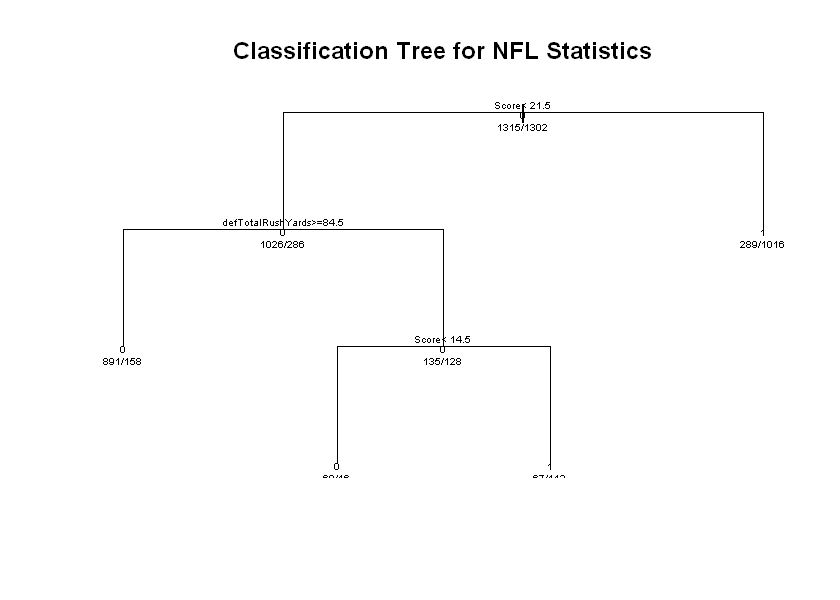

In [41]:
##------------------------------------------------------------------------
## Technique 3: Use Tree to determine how the variables predict the outcome
##------------------------------------------------------------------------
model_tree <- rpart(Outcome ~., method="class",data=train_nfl_data5,
    control=rpart.control(minsplit=100, cp=0.009))

est_train_tree <- predict(model_tree,train_nfl_data5 %>% 
                          select(-Outcome),type="class")
est_test_tree  <- predict(model_tree,test_nfl_data5 %>% 
                          select(-Outcome),type="class")
## Show classification and error using tree model
cat("Classification for the training dataset under Tree:")
table(est_train_tree, true_outcome_train)
cat("Error Rate for the training dataset under Tree:")
round(mean(est_train_tree!=true_outcome_train),4)
cat("\n")
cat("Classification for the test dataset under Tree:")
table(est_test_tree, true_outcome_test)
cat("Error Rate for the test dataset under Tree:")
round(mean(est_test_tree!=true_outcome_test),4)

## Show the misclassifications
misclass_test_tree  <- ifelse(est_test_tree!=true_outcome_test,1,0)


## Tree of Model
plot(model_tree, uniform=TRUE,
   main="Classification Tree for NFL Statistics")
text(model_tree, use.n=TRUE, all=TRUE, cex=.5)

## Discuss of Decision Tree
When implementing the tree method, it is important to note that overfitting was not a problem compared to the SVM and random forest methods, however, the error rate for the training data set was comparable to the test data set. The tree method is critical for this study because it allows one to analyze thresholds for certain outcomes to occur. For example, if you score 21.5 points, a teams has a greater odds of winning. The total defensive rush yards and score are the only variables used within this tree based on the critical parameter set to 0.009. Though prunning was not implemented in this study, there are more variables that can be used to determine the outcome of a game based on these statistics. 

In [19]:
df = rbind(train_nfl_data5, test_nfl_data5)
model_boost <- gbm(Outcome~.,data=train_nfl_data5,n.trees=100,distribution="gaussian",shrinkage=0.8)
est_train_boost <- ifelse(predict(model_boost,newdata=train_nfl_data5 %>% 
                               select(-Outcome),type='response',n.trees=100)>0.5,1,0)
est_test_boost <- ifelse(predict(model_boost,newdata=test_nfl_data5 %>% 
                               select(-Outcome),type='response',n.trees=100)>0.5,1,0)



table(test_nfl_data5$Outcome, est_test_boost)
table(train_nfl_data5$Outcome, est_train_boost)

   est_test_boost
      0   1
  0 250  65
  1  46 292

   est_train_boost
       0    1
  0 1106  214
  1  195 1102

# Discussion of XGBoost

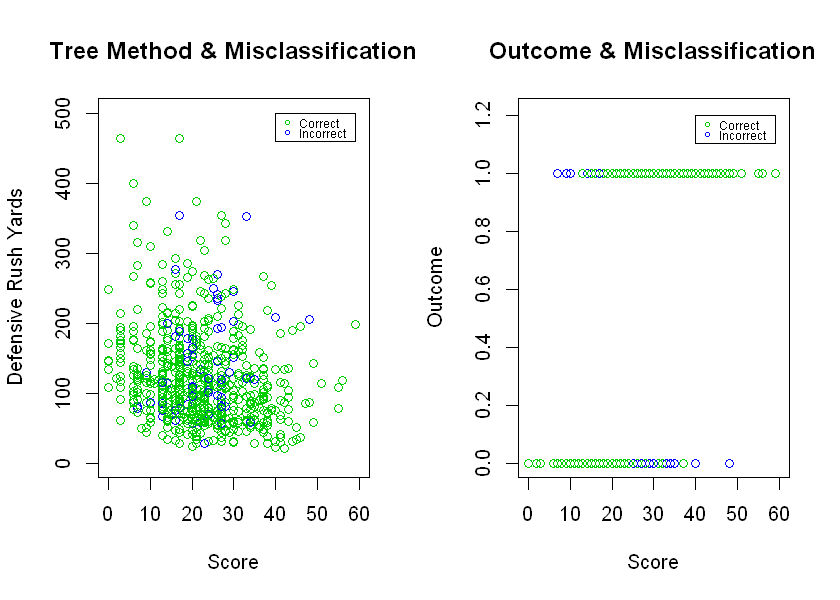

In [42]:
## Misclassified by all three models
misclass_test_all <- ifelse((misclass_test_RF*
                             misclass_test_tree*
                             misclass_test_svm) == 1,1,0)
options(repr.plot.width=7, repr.plot.height=5)
par(mfrow=c(1,2))
plot(test_nfl_data5$Score,test_nfl_data5$defTotalRushYards,
     col=misclass_test_all+3,
    xlab="Score",xlim=c(0,60),
    ylab="Defensive Rush Yards",ylim=c(0,501),
    main="Tree Method & Misclassification")
legend(40,500,c("Correct","Incorrect"),col=c(3,4),cex=0.6,pch=c(1,1))
plot(test_nfl_data5$Score,test_nfl_data5$Outcome,
     col=misclass_test_all+3,
     xlab="Score",xlim=c(0,60),
     ylab="Outcome",ylim=c(0,1.21),
     main="Outcome & Misclassification")
legend(40,1.2,c("Correct","Incorrect"),col=c(3,4),cex=0.6,pch=c(1,1))


## Conclusion
In conclusion, the statistics that were chosen were able to determine the outcome of a game using the SVM, random forest and tree techniques. Though the SVM and random forest techniques  had a problem of over-fitting, all three models were comparable in predicting the test data set outcomes. The tree method showed that the score and defensive rush yard total were indicative in terms of the outcome of a game. However, there were not patterns shown using these two variables with respect to the misclassified games (above right figure). However, a pattern is shown with the misclassified games when comparing score and outcome (above left figure). The misclassfied games occured when the score was large and the team lost as well as when the score was small and the teams won. These anomalies occurr only when the games are close in score in which the statistics of the game cannot predict the outcome. 

Further analysis of this study would be to cross validate these methods by either varying the cost function within the SVM model or pruning the tree within the tree method. This would allow for a better model within each technique to improve the prediction of the outcome of a game. It is important to note that the curation of the data set only used 8 statistics for each team. Every game has more statistics that can be used to predict the outcome of a game. A deeper study could analyze how various statistics relate to one another to predict the outcome of a game.